In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import F1Score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

In [3]:
np.random.seed(42)
torch.random.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:

# XT = np.load('sideData/TrainX.npy', allow_pickle=True)
# XV = np.load('sideData/ValX.npy', allow_pickle=True)

scaler = StandardScaler()
XT = scaler.fit_transform(np.load('sideData/TrainX.npy', allow_pickle=True))
XV = scaler.transform(np.load('sideData/ValX.npy', allow_pickle=True))

YT = np.load('sideData/TrainY.npy', allow_pickle=True)
YV = np.load('sideData/ValY.npy', allow_pickle=True)

XT = torch.Tensor(XT).float()
XV = torch.Tensor(XV).float()

YT = torch.Tensor(YT).long()
YV = torch.Tensor(YV).long()

print(XT.shape)
print(XV.shape)
print(YT.shape)
print(YV.shape)

torch.Size([6251, 9])
torch.Size([300, 9])
torch.Size([6251])
torch.Size([300])


In [5]:
TrainSet = TensorDataset(XT, YT)
TrainSet = DataLoader(dataset=TrainSet, shuffle=True, batch_size=64)

ValSet = TensorDataset(XV, YV)
ValSet = DataLoader(ValSet, shuffle=True, batch_size=64)

In [6]:
class Decider(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(9,3, dtype=torch.float32)
        # self.norm = nn.BatchNorm1d(3)
        
    def forward(self,x):
        x = self.linear(x)
        # x = self.norm(x)     
        return x
    

In [ ]:
weights = [0.4305,0.2994,0.2700]
weights = torch.Tensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

learningRates = np.concatenate([np.linspace(float(f"1e-{i}"), float(f"1e-{i+1}"), 10) for i in range(0,3)])
wCandidates = [float(f"1e-{n}") for n in range(2,6)]
wCandidates.append(0)

epochs = 50
patience = 10
bestLoss = float('inf')
bestParams = {}
for o in ['adam', 'sgd']:
    for l in learningRates:
        for w in wCandidates:
            cntPatience = 0
            decider = Decider().to(device)
            if o == 'adam':
                optimizer = optim.Adam(decider.parameters(), lr=l, weight_decay=w)
            else:
                optimizer = optim.SGD(decider.parameters(), lr=l, weight_decay=w)
            for epoch in range(epochs):
                decider.train()
                train_loss = 0

                for batch_X, batch_y in TrainSet:
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = decider(batch_X)  # shape: [batch_size, num_classes]
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                train_loss /= len(TrainSet)
                decider.eval()
                val_loss = 0
                correct = 0
                total = 0

                with torch.no_grad():
                    for val_X, val_y in ValSet:
                        val_X = val_X.to(device)
                        val_y = val_y.to(device)
                        val_outputs = decider(val_X)
                        loss = criterion(val_outputs, val_y)
                        val_loss += loss.item()

                        _, predicted = torch.max(val_outputs, dim=1)
                        correct += (predicted == val_y).sum().item()
                        total += val_y.size(0)
                val_loss /= len(ValSet)
                torch.save(decider.linear.state_dict(), f'deciderSaves/last.pth')
                
                accuracy = 100 * correct / total
                #print(f"Epoch [{o.upper()}][{epoch+1}/{epochs}]-LR={l} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")
                
                if val_loss < bestLoss:
                    bestLoss = val_loss
                    bestParams = {
                        "lr":l,
                        "weight":w,
                        "optimizer":o
                    }
                    cntPatience = 0
                    torch.save(decider.linear.state_dict(), 'deciderSaves/_best.pth')
                else:
                    cntPatience += 1
                    if cntPatience >= patience:
                        print("Early Stop Triggered -> Best: ",bestLoss)
                        break
            decider.linear.load_state_dict(torch.load('deciderSaves/_best.pth'))

Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978
Early Stop Triggered -> Best:  0.9391485452651978


In [23]:
weights = [0.4305,0.2994,0.2700]
weights = torch.Tensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
f1 = F1Score(task="multiclass", num_classes=3, average='weighted').to(device)

learningRates = np.concatenate([np.linspace(float(f"1e-{i}"), float(f"1e-{i+1}"), 10) for i in range(0,3)])
wCandidates = [float(f"1e-{n}") for n in range(2,6)]
wCandidates.append(0)
oCandidates = ['adam', 'sgd']


epochs = 50
patience = 10
bestScore = -float('inf')
bestParams = {}
for o in oCandidates:
    for l in learningRates:
        for w in wCandidates:
            cntPatience = 0
            decider = Decider()
            decider = decider.to(device)
            if o == 'adam':
                optimizer = optim.Adam(decider.parameters(), lr=l, weight_decay=w)
            else:
                optimizer = optim.SGD(decider.parameters(), lr=l, weight_decay=w)
            for epoch in range(epochs):
                decider.train()
                train_loss = 0

                for batch_X, batch_y in TrainSet:
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = decider(batch_X)  # shape: [batch_size, num_classes]
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                train_loss /= len(TrainSet)
                decider.eval()
                val_loss = 0
                val_f1 = 0
                correct = 0
                total = 0

                with torch.no_grad():
                    for val_X, val_y in ValSet:
                        val_X = val_X.to(device)
                        val_y = val_y.to(device)
                        val_outputs = decider(val_X)
                        score = f1(val_outputs.softmax(1).argmax(1), val_y)
                        loss = criterion(val_outputs, val_y)
                        val_loss += loss.item()
                        val_f1 += score

                        _, predicted = torch.max(val_outputs, dim=1)
                        correct += (predicted == val_y).sum().item()
                        total += val_y.size(0)
                val_loss /= len(ValSet)
                val_f1 /= len(ValSet)
                torch.save(decider.linear.state_dict(), f'deciderSaves/last.pth')
                
                accuracy = 100 * correct / total
                #print(f"Epoch [{o.upper()}][{epoch+1}/{epochs}]-LR={l} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")
                
                if val_f1 > bestScore:
                    bestScore = val_f1
                    bestParams = {
                        "lr":l,
                        "weight":w,
                        "optimizer":o
                    }
                    cntPatience = 0
                    torch.save(decider.linear.state_dict(), 'deciderSaves/_best.pth')
                else:
                    cntPatience += 1
                    if cntPatience >= patience:
                        #print("Early Stop Triggered -> Best: ",bestLoss)
                        break
            decider.linear.load_state_dict(torch.load('deciderSaves/_best.pth'))

tensor(0.7300)


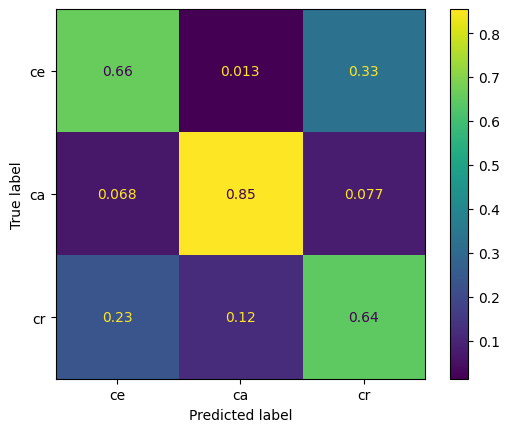

In [24]:
decider.eval()
predictions = decider(XV.to(device)).softmax(1).argmax(1).cpu()
print((predictions == YV).sum()/YV.size()[0])
cfm = confusion_matrix(y_true=YV, y_pred=predictions, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['ce', 'ca', 'cr'])
disp.plot()
plt.show()

In [25]:
print(bestParams)

{'lr': 0.004, 'weight': 0, 'optimizer': 'sgd'}
